# Solar-powered pump

A solar-powered pump transports water from a source underground up to a tank. The PV solar panel converts solar energy into electrical power with an efficiency of $\eta_{\text{PV}} = 0.08$ and stores the electrical energy in a battery, which powers the pump continuously. The 24-hour annual average solar flux is SF = 225 W/m$^2$.

The isentropic efficiency of the pump is 0.58, and the pump performance is given as pressure head versus flow rate:

| Head (ft)     | Flow rate (gpm) |
| ------------- | --------------- |
| 60            | 0               |
| 60            | 2               |
| 57            | 4               |
| 52            | 6               |
| 44            | 8               |
| 33            | 10              |
| 18            | 12              |
| 0             | 14              |

The water source is 20 ft below ground level (where the tank is located), so the pump must provide a pressure rise equal to the 20 ft of water. There is also head loss due to friction in the pipe; the total head loss (pressure drop due to friction) between the inlet and outlet is:
\begin{equation}
\Delta P_{\text{pipe}} = 20 \left[ \text{ft H}_2 \text{O} \right] + 0.085 \left[ \frac{ \text{ft H}_2 \text{O} }{\text{gpm}^2} \right] \dot{V}^2
\end{equation}
where $\dot{V}$ is the volumetric flow rate.

We can assume water is an incompressible fluid here.

**Problem**:

- Determine the flow rate delivered by the pump
- Determine the area of the solar panel required by the system

In [1]:
import numpy as np
from scipy import optimize
import cantera as ct

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# these are mostly for making the saved figures nicer
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

## Determine the flow rate of water delivered

First, specify the input information:

In [3]:
solar_flux = Q_(225, 'W/m^2')
efficiency_pump = 0.58
efficiency_solar = 0.08

Next, to model the pump, we can fit the performance data to a third-order polynomial:
\begin{equation}
\Delta P_{\text{pump}} = a_0 + a_1 \dot{V} + a_2 \dot{V}^2 + a_3 \dot{V}^3
\end{equation}

We can find this fit using the NumPy function `polyfit()`, and place the result in a `poly1d` object so we can easily evaluate the polynomial:

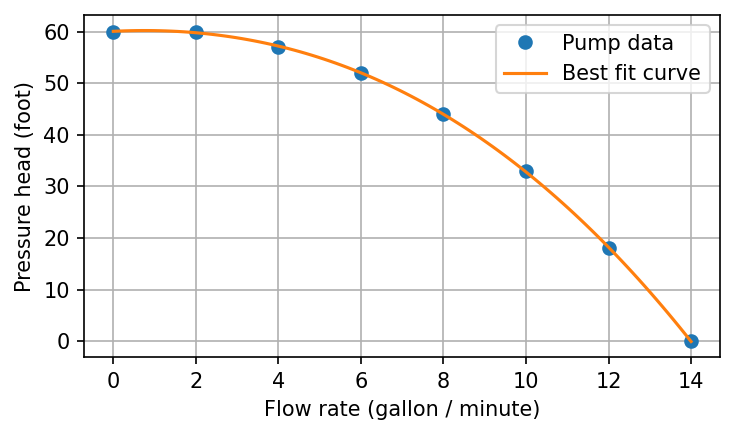

In [14]:
# Construct NumPy arrays with the pressure head and 
# flow rate from the table
head = Q_(np.asarray([60, 60, 57, 52, 44, 33, 18, 0]), 'ft')
flow_rate = Q_(np.asarray([0, 2, 4, 6, 8, 10, 12, 14]), 'gallon per minute')

# Perform the fit with degree 3, and place in a poly1d object
pump_fit = np.poly1d(np.polyfit(flow_rate.magnitude, head.magnitude, 3))

fig, ax = plt.subplots(figsize=(5, 3))

# Plot the measurements
ax.plot(flow_rate.magnitude, head.magnitude, 'o')

# Generate a dense sample of flow rate values, then plot the polynomial fit
flow_rate_dense = np.linspace(flow_rate[0].magnitude, flow_rate[-1].magnitude, 100)
ax.plot(flow_rate_dense, pump_fit(flow_rate_dense))

plt.xlabel(f'Flow rate ({flow_rate.units})')
plt.ylabel(f'Pressure head ({head.units})')
plt.grid(True)
plt.legend(['Pump data', 'Best fit curve'])
fig.tight_layout()
plt.show()

To find the volumetric flow rate of the pump, we need to find the condition where the pressure head of the pump matches the pressure drop of the pipe between the inlet and outlet. We can do this by setting two $\Delta P$ expressions equal to each other, and the finding the root of this equation:
\begin{equation}
\Delta P_{\text{pump}} \left(\dot{V}\right) = \Delta P_{\text{pipe}} \left(\dot{V}\right)
\end{equation}

To find the root, we can use the [SciPy function `root_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html), part of its `optimize` module. This needs needs us to provide a function that rearranges the above expression to equal zero, and returns that value. In other words, the function should return:
\begin{equation}
\Delta P_{\text{pump}} \left(\dot{V}\right) - \Delta P_{\text{pipe}} \left(\dot{V}\right)
\end{equation}
which will equal zero when the root is found.

In [10]:
def pump_performance(volume_flow_rate, pump_fit):
    '''Find root of pump performance equations'''
    deltaP_pump = pump_fit(volume_flow_rate) * ureg.ft
    volume_flow_rate *= ureg('gal/min')
    deltaP_pipe = (
        Q_(20, 'ft') + 
        Q_(0.085, 'ft/((gal/min)**2)') * volume_flow_rate**2
        )
    return (deltaP_pump - deltaP_pipe).to('ft').magnitude

Then, we call the `root_scalar` function, giving it the function we just created along with a range of possible values and the extra argument our function needs:

In [11]:
sol = optimize.root_scalar(
    pump_performance, bracket=[0, 14], 
    args=(pump_fit,),
    )

volume_flow_rate = Q_(sol.root, 'gal/min')
print(f'Pump flow rate: {volume_flow_rate: .2f}')

Pump flow rate: 10.51 gallon / minute


## Determine area of solar panels required

To determine the area of solar panels required, we first need to calculate the work needed for the pump:

$$
\dot{W}_p = \frac{\dot{m} v \Delta P_{\text{pump}} }{\eta_p} = \frac{\dot{V} \Delta P_{\text{pump}} }{\eta_p}
$$

First, however, we'll need to convert the pressure head (given in feet of water) to an actual pressure difference, using $h = \frac{P}{\rho g}$.

In [16]:
pressure_head = Q_(pump_fit(volume_flow_rate.magnitude), 'ft')
water = ct.Water()
pressure_drop = pressure_head * Q_(water.density, 'kg/m^3') * ureg.gravity

work_pump = (
    volume_flow_rate * pressure_drop.to('Pa') / 
    efficiency_pump
    )
print(f'Pump work: {work_pump.to(ureg.watt): .2f}')

Pump work: 100.13 watt


Finally, we can calculate the area required by relating the power generated by the solar panels to the rate of work required by the pump:

$$
\text{SF} \, A \eta_{\text{PV}} = \dot{W}_p
$$

In [17]:
area_solar = work_pump / (solar_flux * efficiency_solar)
print(f'Area of solar panels required: {area_solar.to("m^2"): .2f}')

Area of solar panels required: 5.56 meter ** 2
